In [10]:
%load_ext autoreload
%autoreload 2
import os
import matplotlib.pyplot as plt
import seaborn as sns
from os.path import join
from tqdm import tqdm
import pandas as pd
import sys
from typing import List
import numpy as np
import joblib
from pprint import pprint
from math import ceil
import imodelsx.util
import sasc.viz
import pickle as pkl
import json
from copy import deepcopy
from numpy.linalg import norm
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize

from PIL import Image
import img2pdf


from sasc.config import CACHE_DIR, RESULTS_DIR, cache_ngrams_dir, regions_idxs_dir, FMRI_DIR, SAVE_DIR_FMRI
import sasc.modules.fmri_module
from imodels import StableClustering
ngrams_list = joblib.load(join(cache_ngrams_dir, 'fmri_UTS02_ngrams.pkl')) # ngrams are same for both models

subject = 'S02'
# subject = 'S03'
# rois_dict = joblib.load(join(regions_idxs_dir, f'rois_{subject}.jbl'))
# sorted(rois_dict.keys())
# if subject == 'S03':
#     rois_dict['OPA'] = rois_dict['TOS']

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
mod = sasc.modules.fmri_module.fMRIModule(
    subject=f"UT{subject}",
    # checkpoint="facebook/opt-30b",
    checkpoint="huggyllama/llama-30b",
    init_model=False,
    restrict_weights=False,
)
weights_arr_full = mod.weights
# weights_arr_full has shape (num_delays x num_linear_coefs, num_voxels)

initializing fmri...


/home/chansingh/.env/lib/python3.11/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.2.2 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [ ]:
# mean over delays
# weights_arr_to_cluster = weights_arr_full.reshape(
# 4, -1, weights_arr_full.shape[1]).mean(axis=0)
# has shape (num_linear_coefs, num_voxels)

In [ ]:
# pca
num_pcs = 5
pca = PCA(n_components=num_pcs, whiten=True)

X = weights_arr_full.T
X_normalized = normalize(X)
pca.fit(X_normalized)
# pca.components_.shape is (num_pcs, num_linear_coefs)

pc_coefs_per_voxel = pca.transform(X_normalized)
# pc_coefs_per_voxel.shape is (num_voxels, num_pcs)

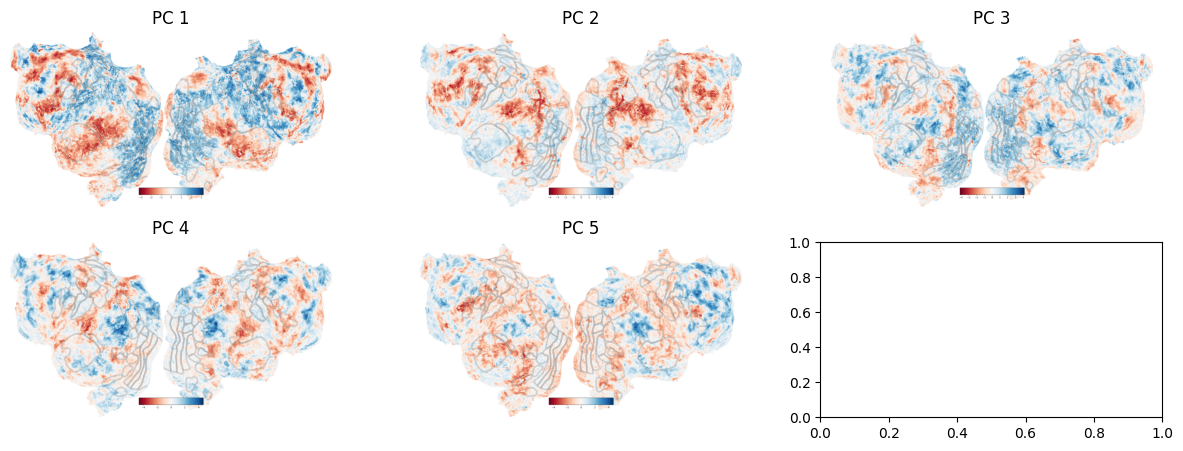

In [ ]:
# run pca
for pc_num in range(num_pcs):
    flatmap = pc_coefs_per_voxel[:, pc_num]
    sasc.viz._save_flatmap(flatmap, 'S02', fname_save=f'./pca_{pc_num+1}.png')

# read all plots and save as subplots on the same page
fig, axs = plt.subplots(ceil(num_pcs/3), 3, figsize=(15, 5))
axs = axs.ravel()
for i in range(num_pcs):
    axs[i].imshow(Image.open(f'./pca_{i+1}.png'))
    axs[i].axis('off')
    axs[i].set_title(f'PC {i + 1}')
plt.savefig('pca_subplots.png')